In [1]:
import os, sys
import numpy as np

## LSST libraries

In [2]:
import lsst.sims.maf
lsst.sims.maf.__version__

'2.4.2.sims'

In [3]:
%matplotlib inline   
import matplotlib.pyplot as plt

In [4]:
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

## surveysim libraries

In [5]:
os.environ["SURVEYSIM_PATH"] = "/home/fforster/Work/surveysim"
sys.path.append("%s/lib" % os.environ["SURVEYSIM_PATH"])

In [6]:
from constants import *
from obsplan import *
from LCz import *
from LCz_Av import *
from LCz_Av_params import *
from SFHs import *
from survey_multimodel import *
from survey_multimodel_metric import *

# Cosmology stuff                                                                                                                                     
import cos_calc 

## Load SN models

In [7]:
modelname = "MoriyaWindAcc"

In [8]:
# load models                                                                                                                                                                                                   
modelsdir = "%s/models" % os.environ["SURVEYSIM_PATH"]
data = np.genfromtxt("%s/%s/modellist.txt" % (modelsdir, modelname), dtype = str, usecols = (0, 1, 3, 5, 7, 9, 10, 11)).transpose()
data[data == 'no'] = 0
modelfile, modelmsun, modele51, modelmdot, modelrcsm, modelvwind0, modelvwindinf, modelbeta = data
# parameters, specific to MoriyaWindAcc models                                                                                                                                                                  
modelfile = np.array(modelfile, dtype = str)
modelmsun = np.array(modelmsun, dtype = float)
modelfoe = np.array(modele51, dtype = float) / 1e51
modelmdot = np.array(modelmdot, dtype = float)
modelrcsm = np.array(modelrcsm, dtype = float) / 1e15
modelvwind0 = np.array(modelvwind0, dtype = float)  # do not use this                                                                                                                                           
modelvwindinf = np.array(modelvwindinf, dtype = float)
modelbeta = np.array(modelbeta, dtype = float)
params = np.vstack([modelmsun, modelfoe, modelmdot, modelrcsm, modelvwindinf, modelbeta]).transpose()
try:
    files = np.array(list(map(lambda name: "%s.fr" % name, modelfile)))
except:
    files = "%s.fr" % modelf

In [9]:
# Redshift, Avs and time grids                                                                                                                                                                                        
nz = 30
ntimes = 100
nAvs = 10
zs = np.logspace(-3, 0, nz)
times = np.logspace(-3, 3, ntimes)
Avs = np.logspace(-4, 1, nAvs)
Rv = 3

In [10]:
# initialize LCz_Av_params models                                                                                                                                                                               
paramnames = ["mass", "energy", "mdot", "rcsm", "vwindinf", "beta"]
paramunits = ["Msun", "B", "Msun/yr", "1e15 cm", "km/s", ""]
parammetric = np.array([1., 1., 1e-6, 1., 10., 1.])
paramlogscale = np.array([False, False, True, False, False, True], dtype = bool)
LCs = LCz_Av_params(modelsdir = modelsdir, modelname = modelname, files = files, \
                    paramnames = paramnames, paramunits = paramunits, params = params, \
                    zs = zs, Avs = Avs, Rv = Rv, times = times)

['mass' 'energy' 'mdot' 'rcsm' 'vwindinf' 'beta']


In [11]:
# do cosmology                                                                                                                                                                                                  
LCs.docosmo()

In [12]:
# compute models in given bands                                                                                                                                                                                 
LCs.compute_models(bands = ['g', 'r'], load = True)

In [13]:
# set metric for interpolation
LCs.setmetric(metric = parammetric, logscale = paramlogscale)

In [14]:
# set bands and band colors, leave observations empty (they are filled in inside metric for every healpix)
LCs.set_observations(mjd = None, filters = None, flux = None, e_flux = None, \
                     objname = None, plot = False, \
                     bandcolors = {'u': 'gray', 'g': "green", 'r': 'r', 'i': 'brown', 'z': 'k'})

In [15]:
# maximum age of object at the start of the survey
maxrestframeage = 3.

## Star formation history

In [16]:
# star formation                                                                                                                                                                                                
SFH = SFHs(SFH = "MD14")
knorm = 0.0091
IIPfrac = 0.54
efficiency = knorm * IIPfrac

## Create observational plan

In [17]:
# start empty observational plan    
plan = obsplan(obsname = "LSST", mode = 'maf', MJDs = None, limmag = None, bands = None)

## Default parameters, distributions and bounds

In [18]:
# default physical values
mass = None
energy = None
mdot = None
rcsm = 1. # 1e15
vwindinf = 10.
beta = None
pars = np.array([mass, energy, mdot, rcsm, vwindinf, beta]) # must be in same order as paramnames

In [19]:
# set distribution of physical parameters, leavinng time empty
rvs = {'texp': None, \
       'logAv': lambda nsim: norm.rvs(loc = np.log(0.1), scale = 1., size = nsim), \
       'mass': lambda nsim: uniform.rvs(loc = 12., scale = 4., size = nsim), \
       'energy': lambda nsim: norm.rvs(loc = 1., scale = 1., size = nsim), \
       'log10mdot': lambda nsim: uniform.rvs(loc = -8, scale = 6, size = nsim), \
       'beta': lambda nsim: uniform.rvs(loc = 1., scale = 4., size = nsim)}
bounds = {'texp': None, \
          'logAv': [np.log(1e-4), np.log(10.)], \
          'mass': [12, 16], \
          'energy': [0.5, 2.], \
          'log10mdot': [-8, -2], \
          'beta': [1., 5.]}

## LSST metric, slicer and sql constraint to form a metric bundle

In [20]:
# reference survey                                                                                 
refsurvey = survey_multimodel(obsplan = plan, SFH = SFH, efficiency = efficiency, LCs = LCs, maxrestframeage = maxrestframeage)

In [21]:
# use survey_multimodel_metric
nsim = 1000
maxz = 0.4
surveymetric = survey_multimodel_metric(refsurvey = refsurvey, rvs = rvs, bounds = bounds, \
                                        pars = pars, nsim = nsim, maxz = maxz)

In [22]:
# slicer = a grouping or subdivision of visits for the simulated survey based on their position on the sky 
# (using a Healpix grid)
nside = 16
npixel =  12 * nside**2
slicer1 = slicers.HealpixSlicer(nside=nside, latLonDeg=False)
print(npixel)

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
3072


In [23]:
# use r filter
sqlconstraint= 'filter = "g" OR filter = "r"'

In [24]:
# create bundle
bundle1 = metricBundles.MetricBundle(surveymetric, slicer1, sqlconstraint)

In [25]:
opsdb = db.OpsimDatabaseV3('/home/fforster/lsst/mafdb/minion_1016_sqlite.db')
outDir = 'output_directory'
resultsDb = db.ResultsDb(outDir=outDir)

In [26]:
bundleDict = {'surveysim': bundle1}

In [27]:
group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)

# Run simulations

In [28]:
%time group.runAll()

Querying database Summary with constraint filter = "g" OR filter = "r" for columns ['fieldRA', 'fieldDec', 'fiveSigmaDepth', 'expMJD', 'filter']
Found 785380 visits
Running:  ['surveysim']


/home/fforster/Work/surveysim/lib/survey_multimodel.py:358: RuntimeWarning: invalid value encountered in true_divide
  self.y_effs[vallabel] = 1. * nout / nin


1946Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
CPU times: user 2h 25min 39s, sys: 10.7 s, total: 2h 25min 50s
Wall time: 3h 57min 6s


Plotting figures with "filter = "g" OR filter = "r"" constraint now.
monopole: 1487.22  dipole: lon: -21.0598, lat: -27.7277, amp: 400.636
Plotting complete.


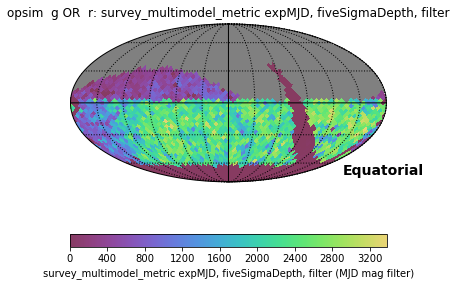

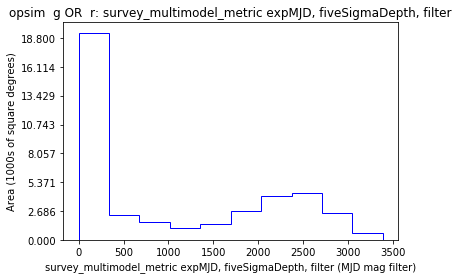

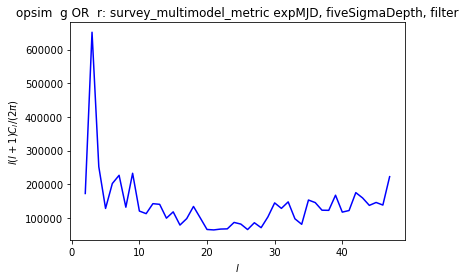

In [29]:
group.plotAll(closefigs=False)